In [ ]:
import IPython.display
import librosa
import librosa.display
import pandas as pd
import os
import struct
import json
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
# Se obtienen las diferentes rutas de los datos, tanto audios como metadata y path para obtener las muestras
file_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/UrbanSound8K/audio'
urbansound8k = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/UrbanSound8K/metadata/UrbanSound8K.csv')
file_viz = glob.glob('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/UrbanSound8K/audio/fold1/*')

In [ ]:
#pd.set_option('display.max_rows', None)
urbansound8k.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [ ]:
#Se organiza dataset para seleccionar la clase de interes y las otras renombrarse como no interes
urbansound8k.loc[urbansound8k["class"] != "siren", "class"] = "non_siren"

In [ ]:
#Se cambian los valores de la columna classID para identificar unicamente las dos clases de interes
urbansound8k.loc[urbansound8k["classID"] != 8, "classID"] = 1
urbansound8k.loc[urbansound8k["classID"] == 8, "classID"] = 0

In [ ]:
urbansound8k.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,1,non_siren
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,1,non_siren
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,1,non_siren
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,1,non_siren
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,1,non_siren


In [ ]:
#se cuenta el numero total de muestras de la clase de interes 
totalSamples =  urbansound8k.loc[((urbansound8k["class"]=="siren"))].count()[0]

In [ ]:
#se toma una muestra aleatoria del tamaño de las muestras de la clase de interes para que quede balanceado
urbansound8k[urbansound8k['class'] == "non_siren"].sample(n=totalSamples).head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
2364,156362-4-3-6.wav,156362,312.117912,316.117912,2,4,1,non_siren
2592,159702-6-2-0.wav,159702,1.174665,1.768990,1,6,1,non_siren
6102,33340-7-11-0.wav,33340,53.200224,56.339909,1,8,1,non_siren
6023,30206-7-0-2.wav,30206,1.000000,5.000000,1,6,1,non_siren
7306,68080-7-0-4.wav,68080,2.000000,6.000000,1,8,1,non_siren


In [ ]:
#se toma una muestra aleatoria del tamaño de las muestras de la clase de interes para que quede balanceado 
dfNonSiren = urbansound8k[urbansound8k['class'] == "non_siren"].sample(n=totalSamples)
dfSiren = urbansound8k[urbansound8k['class'] == "siren"]

In [ ]:
#se unen en un solo dataset las clases de interes con muestras balanceadas
dfComplete = dfNonSiren.append(dfSiren)
dfComplete.count()[0]

1858

In [ ]:
dfComplete[dfComplete['class'] == "siren"].count()[0]

929

In [ ]:
dfComplete[dfComplete['class'] == "non_siren"].count()[0]

929

In [ ]:
#Se cambia el dataset para unicamente tomar las clases de interés para el trabajo
dfComplete.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
2224,155212-9-1-88.wav,155212,176.167185,180.167185,1,6,1,non_siren
193,103076-3-0-0.wav,103076,0.000000,2.527184,1,8,1,non_siren
1598,139948-3-0-0.wav,139948,1.066204,4.182799,2,5,1,non_siren
2341,156091-1-0-0.wav,156091,1.175595,2.922300,2,7,1,non_siren
2789,159761-0-0-2.wav,159761,1.000000,5.000000,2,3,1,non_siren


In [ ]:
class_map = {'0' : 'air_conditioner', '1' : 'car_horn', '2' : 'children_playing', '3' : 'dog_bark', '4' : 'drilling', 
                 '5' : 'engine_idling', '6' : 'gun_shot', '7' : 'jackhammer', '8' : 'siren', '9' : 'street_music'}
#Se crea el mapa de las clases a utilizar
class_map = {'8' : 'siren', '5' : 'non_siren',}
pd.DataFrame(sorted(list(class_map.items())))

,0,1
0,5,non_siren
1,8,siren


In [ ]:
#Se toman muestras del dataset para ser previsualizadas
samples = [(class_map[label], [f for f in file_viz if f.split('-')[1] == label][0]) 
           for label in class_map.keys()]

In [ ]:
#Funcion para obtener los datos del sonido muestreados a una tasa de 22050 por defecto.
def get_sound_data(path, sr=22050):
    data, fsr = sf.read(path)
    data_22k = librosa.resample(data.T, fsr, sr)
    if len(data_22k.shape) > 1:
        data_22k = np.average(data_22k, axis=0)
    return data_22k, sr
sample_data = [(sample[0], get_sound_data(sample[1])) for sample in samples]
[(sample[0], sample[1][0].shape) for sample in sample_data]

[('siren', (88200,)), ('non_siren', (88200,))]

In [ ]:
#Se despliegan las muestras de los datos para ser reproducidas.
for data in sample_data:
    print(data[0], ':')
    IPython.display.display(IPython.display.Audio(data=data[1][0], rate=data[1][1]))

siren :


non_siren :


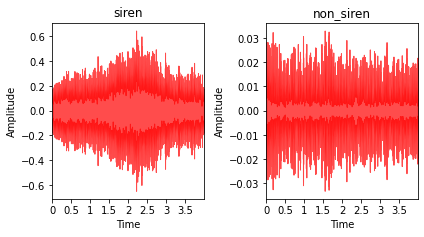

In [ ]:
#Se despliega la forma de onda para las muestras tomadas
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    librosa.display.waveplot(item[1][0], sr=item[1][1], color='r', alpha=0.7)
    plt.title(item[0])
    plt.ylabel("Amplitude")
    i += 1
plt.tight_layout()

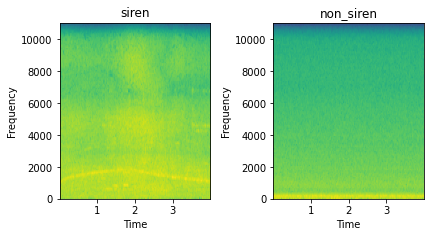

In [ ]:
#Se muestran los espectogramas correspondeintes a las muestras tomadas.
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    specgram(item[1][0], Fs=item[1][1])
    plt.title(item[0])
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    i += 1
plt.tight_layout()

Extracting features using Librosa

In [ ]:
#Se define funcion para extrar las caracteristicas con la librería librosa, obetiendo los coeficientes ceptrales de frecuencia de Mel
#Se realiza un pading en el tamaño para que concuerden los tamaños de las caracteristicas de entrada al modelo.

def extract_features(file_name, Nmfcc, Nfft, NhopL, NwinL):
    
    samplerate = 22050
    longitudMaxAudio = 4
    max_pad_len = int(samplerate*longitudMaxAudio/NhopL) + int(samplerate*longitudMaxAudio/NhopL*0.07)  #Calculo longitud de salida de mfcc con 5% de tolerancia para longitud de audios

    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=Nmfcc, n_fft=Nfft, hop_length=NhopL, win_length=NwinL)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
    #print(mfccs.shape) 
    return mfccs

In [ ]:
#Se realiza la extracción de caracteristicas, teniendo en cuenta la clase, si el sonido es de la carpeta agregada de la clase explosions va y busca este sonido en la carpeta requerida

def get_features(Nmfcc, Nfft, NhopL, NwinL):
  features = []

  # Iterate through each sound file and extract the features 
  for index, row in dfComplete.iterrows():
      
      file_name = os.path.join(os.path.abspath(file_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
      
      class_label = row["classID"]
      data = extract_features(file_name, Nmfcc, Nfft, NhopL, NwinL)
      
      features.append([data, class_label])

  # Convert into a Panda dataframe 
  featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
  #featuresdf[featuresdf['class_label'] == 0].count()[0]
  return featuresdf

In [ ]:
def splitFeaturesTrainTest(featuresdf, num_rows, num_columns, num_channels):
  X = np.array(featuresdf.feature.tolist())
  y = np.array(featuresdf.class_label.tolist())

  # Encode the classification labels
  le = LabelEncoder()
  yy = to_categorical(le.fit_transform(y)) 

  # split the dataset 
  from sklearn.model_selection import train_test_split 

  x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 3)

  x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
  x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)
  num_labels = yy.shape[1]
  return x_train, x_test, y_train, y_test, num_labels

#Creating the Model

In [ ]:
# Constructing model with RELu and SoftMax activation functions:
def getModel(num_rows, num_columns, num_channels, num_labels, k_size):
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=k_size, input_shape=(num_rows, num_columns, num_channels), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=32, kernel_size=k_size, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=k_size, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=128, kernel_size=k_size, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(num_labels, activation='softmax'))
    return model

#DSE SIREN

In [ ]:
specGPU = !nvidia-smi -L
specCPU = !lscpu |grep 'Model name'
specCore = !lscpu | grep 'Core(s) per socket:'

In [ ]:
print(specGPU[0])
print(specCPU[0])
print(specCore[0])

GPU 0: Tesla T4 (UUID: GPU-2eb3ae10-a2c0-ca63-8309-3a6261e1d6b2)
Model name:                      Intel(R) Xeon(R) CPU @ 2.00GHz
Core(s) per socket:              1


In [ ]:

#Model and History container
models = []
histories = []
reports = []
cmatrixs = []
trainAcc = []
testAcc = []
trainTimes = []
numberEpochsRan = []

samplerate = 22050
longitudMaxAudio = 4
valuesNmfcc = [45] #[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45]    #Valores de parametro a variar para el numero de coeficientes MFCC
valuesNfft = [256, 512, 1024, 2048, 4096]    #[256, 512, 1024, 2048, 4096]  #Valores de parametro a variar para la longitud de la FFT
valuesWinL = [256, 512, 1024, 2048, 4096]    #[256, 512, 1024, 2048, 4096] #Valores de parametro a variar para el tamaño de ventana, este debe ser menor o igual a NFFT, la función hace padding con 0
valuesHopL = [0.25, 0.5, 0.75]               #[0.25, 0.5, 0.75] #Valores de parametro a variar para el overlaping opuesto de hop_length
valuesKernelSize = [2, 3, 5]                # [2, 3, 5]    #Valores de parametro de tamaño de kernel a variar dentro del modelo



for Nmfcc in valuesNmfcc:                     #Loop para variar valores del parametro n_mfcc => Numero de coeficientes MFCC
  for Nfft in valuesNfft:                         #Loop para variar valores del parametro n_fft => Tamaño del la FFT
    for iterableNwinL in valuesWinL:              #Loop para variar valores del parametro Win_Length => Longitud de la ventana de muestreo
      if iterableNwinL<=Nfft:
        NwinL = iterableNwinL
      else:
        continue
      for iterableNhopL in valuesHopL:            #Loop para variar valores del parametro Hop_Length => Overlaping
        #if ((Nfft==4096 and NwinL==1024 and iterableNhopL==0.25) or (Nfft==4096 and NwinL==1024 and iterableNhopL==0.5)):
          #continue
        NhopL = int(iterableNhopL*NwinL)
        num_rows = Nmfcc
        num_columns = int(samplerate*longitudMaxAudio/NhopL) + int(samplerate*longitudMaxAudio/NhopL*0.07)  #Calculo longitud de salida de mfcc con 5% de tolerancia para longitud de audios
        num_channels = 1
        
        print(f'N_MFCC= {Nmfcc}, Nfft= {Nfft}, NwinL= {NwinL}, NhopL= {NhopL}')

        startP = datetime.now()
        featuresdf = get_features(Nmfcc, Nfft, NhopL, NwinL)
        durationPreprocessing = datetime.now() - startP
        totalSamples = int(dfComplete.count()[0])
        durationAvgPreprocs = durationPreprocessing/totalSamples

        print('\nPreprocessing Finished For:\n\n')
        print(f'N_MFCC= {Nmfcc}, Nfft= {Nfft}, NwinL= {NwinL}, NhopL= {NhopL}')
        print('\n\nPreprocessing Duration Average Per Sample: \n\n', durationAvgPreprocs)

        x_train, x_test, y_train, y_test, num_labels = splitFeaturesTrainTest(featuresdf, num_rows, num_columns, num_channels)
 
        for k_size in valuesKernelSize:           #Loop para variar valores del parametro kernel size => Tamaño del kernel de capas convolucionales
          #if(Nfft==4096 and NwinL==1024 and iterableNhopL==0.75 and k_size<=2):
            #continue
          models = []
          histories = []
          reports = []
          cmatrixs = []
          trainAcc = []
          testAcc = []
          trainTimes = []
          numberEpochsRan = []
          for i in range(5):                        #Loop para promediar el experimento realizandolo 5 veces con los mismos valores de parametros
            model = getModel(num_rows, num_columns, num_channels, num_labels, k_size)
            #Se compila el modelo con la función de perdida de crosentrpía categorica 
            model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
            # Generate a print
            print('------------------------------------------------------------------------')
            print(f'Training for N_MFCC= {Nmfcc}, Nfft= {Nfft}, NwinL= {NwinL}, NhopL= {NhopL}, Ksize= {k_size}, ...')

            #Entrenamiento del modelo 
            num_epochs = 80
            num_batch_size = 256

            earlystopper = EarlyStopping(patience=10, verbose=0)
            checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/DSE_siren_check', 
                                          verbose=0, save_best_only=True)
            start = datetime.now()
            history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data = (x_test, y_test), callbacks=[earlystopper, checkpointer], verbose=0)
            duration = datetime.now() - start
            print("Training completed in time: ", duration)
            trainTimes.append(duration)

            # Evaluating the model on the training and testing set
            score = model.evaluate(x_train, y_train, verbose=0)
            print("Training Accuracy: ", score[1])
            trainAcc.append(score[1])

            score = model.evaluate(x_test, y_test, verbose=0)
            print("Testing Accuracy: ", score[1])
            testAcc.append(score[1])

            y_true = np.argmax(y_test,axis=1)
            y_pred = np.argmax(model.predict(x_test),axis=1)
            print('\nConfusion Matrix :\n\n')
            print(confusion_matrix(y_true,y_pred))
            print('\n\nClassification Report : \n\n',classification_report(y_true,y_pred))

            # Add trained model, histoy, and reports to container
            numberEpochsRan.append(len(history.history['loss']))
            models.append(model)
            histories.append(history)
            reports.append(classification_report(y_true,y_pred))
            cmatrixs.append(confusion_matrix(y_true,y_pred))

          Experiment = {
            'N_MFCC': Nmfcc,
            'Nfft': Nfft,
            'NwinL': NwinL,
            'NhopL': NhopL,
            'Ksize': k_size,
            'durationAvgPreprocs': durationAvgPreprocs,
            #'models': models,
            #'histories': histories,
            'reports': reports,
            'cmatrixs': cmatrixs,
            'trainAcc': trainAcc,
            'testAcc': testAcc,
            'trainTimes': trainTimes,
            'numberEpochsRan': numberEpochsRan,
            'specGPU': specGPU[0],
            'specCPU': specCPU[0],
            'specCore': specCore[0]
          }
          
          print(Experiment)
          json_object = json.dumps(Experiment, ensure_ascii = False, indent=2, sort_keys=True, default=str)
          print(json_object)

          filenameOutput = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/DSE_siren.json"

          # 1. Read json file
          with open(filenameOutput, "r") as f:
              data = json.load(f)
              f.close() 
          # 2. Update json object
          data["Experiments"].append(Experiment)
          # 3. Write json file
          with open(filenameOutput, "w") as f:
              json.dump(data, f, ensure_ascii = False, indent=2, sort_keys=True, default=str)
              f.close() 


N_MFCC= 45, Nfft= 4096, NwinL= 1024, NhopL= 768


/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=4096 is too small for input signal of length=3206
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=4096 is too small for input signal of length=1323
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=4096 is too small for input signal of length=3954
  warnings.warn(



Preprocessing Finished For:


N_MFCC= 45, Nfft= 4096, NwinL= 1024, NhopL= 768


Preprocessing Duration Average Per Sample: 

 0:00:00.790041
------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 1024, NhopL= 768, Ksize= 2, ...


Training completed in time:  0:00:49.967801
Training Accuracy:  0.9125168323516846
Testing Accuracy:  0.8655914068222046
12/12 [==============================] - 0s 2ms/step

Confusion Matrix :


[[160  20]
 [ 30 162]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.84      0.89      0.86       180
           1       0.89      0.84      0.87       192

    accuracy                           0.87       372
   macro avg       0.87      0.87      0.87       372
weighted avg       0.87      0.87      0.87       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 1024, NhopL= 768, Ksize= 2, ...


Training completed in time:  0:00:51.280794
Training Accuracy:  0.9172274470329285
Testing Accuracy:  0.8629032373428345
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[161  19]
 [ 32 160]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.83      0.89      0.86       180
           1       0.89      0.83      0.86       192

    accuracy                           0.86       372
   macro avg       0.86      0.86      0.86       372
weighted avg       0.86      0.86      0.86       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 1024, NhopL= 768, Ksize= 2, ...


Training completed in time:  0:01:10.201283
Training Accuracy:  0.9273216724395752
Testing Accuracy:  0.8870967626571655
12/12 [==============================] - 0s 2ms/step

Confusion Matrix :


[[167  13]
 [ 29 163]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.85      0.93      0.89       180
           1       0.93      0.85      0.89       192

    accuracy                           0.89       372
   macro avg       0.89      0.89      0.89       372
weighted avg       0.89      0.89      0.89       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 1024, NhopL= 768, Ksize= 2, ...


Training completed in time:  0:01:14.536696
Training Accuracy:  0.9374158978462219
Testing Accuracy:  0.9059139490127563
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[166  14]
 [ 21 171]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.89      0.92      0.90       180
           1       0.92      0.89      0.91       192

    accuracy                           0.91       372
   macro avg       0.91      0.91      0.91       372
weighted avg       0.91      0.91      0.91       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 1024, NhopL= 768, Ksize= 2, ...


Training completed in time:  0:02:22.915421
Training Accuracy:  0.9441453814506531
Testing Accuracy:  0.9059139490127563
12/12 [==============================] - 0s 2ms/step

Confusion Matrix :


[[160  20]
 [ 15 177]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.91      0.89      0.90       180
           1       0.90      0.92      0.91       192

    accuracy                           0.91       372
   macro avg       0.91      0.91      0.91       372
weighted avg       0.91      0.91      0.91       372

{'N_MFCC': 45, 'Nfft': 4096, 'NwinL': 1024, 'NhopL': 768, 'Ksize': 2, 'durationAvgPreprocs': datetime.timedelta(microseconds=790041), 'reports': ['              precision    recall  f1-score   support\n\n           0       0.84      0.89      0.86       180\n           1       0.89      0.84      0.87       192\n\n    accuracy                           0.87       372\n   macro avg       0.87      0.87      0.87       372\

Training completed in time:  0:01:22.884177
Training Accuracy:  0.9609690308570862
Testing Accuracy:  0.9112903475761414
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[170  10]
 [ 23 169]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.88      0.94      0.91       180
           1       0.94      0.88      0.91       192

    accuracy                           0.91       372
   macro avg       0.91      0.91      0.91       372
weighted avg       0.91      0.91      0.91       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 1024, NhopL= 768, Ksize= 3, ...


Training completed in time:  0:00:56.370604
Training Accuracy:  0.9475101232528687
Testing Accuracy:  0.9086021780967712
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[167  13]
 [ 21 171]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.89      0.93      0.91       180
           1       0.93      0.89      0.91       192

    accuracy                           0.91       372
   macro avg       0.91      0.91      0.91       372
weighted avg       0.91      0.91      0.91       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 1024, NhopL= 768, Ksize= 3, ...


Training completed in time:  0:02:22.941382
Training Accuracy:  0.9616419672966003
Testing Accuracy:  0.9220430254936218
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[166  14]
 [ 15 177]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.92      0.92      0.92       180
           1       0.93      0.92      0.92       192

    accuracy                           0.92       372
   macro avg       0.92      0.92      0.92       372
weighted avg       0.92      0.92      0.92       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 1024, NhopL= 768, Ksize= 3, ...


Training completed in time:  0:02:22.951016
Training Accuracy:  0.9629878997802734
Testing Accuracy:  0.9139785170555115
12/12 [==============================] - 0s 4ms/step

Confusion Matrix :


[[159  21]
 [ 11 181]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.94      0.88      0.91       180
           1       0.90      0.94      0.92       192

    accuracy                           0.91       372
   macro avg       0.92      0.91      0.91       372
weighted avg       0.92      0.91      0.91       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 1024, NhopL= 768, Ksize= 3, ...


Training completed in time:  0:01:47.869250
Training Accuracy:  0.9596231579780579
Testing Accuracy:  0.9327957034111023
12/12 [==============================] - 0s 2ms/step

Confusion Matrix :


[[167  13]
 [ 12 180]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.93      0.93      0.93       180
           1       0.93      0.94      0.94       192

    accuracy                           0.93       372
   macro avg       0.93      0.93      0.93       372
weighted avg       0.93      0.93      0.93       372

{'N_MFCC': 45, 'Nfft': 4096, 'NwinL': 1024, 'NhopL': 768, 'Ksize': 3, 'durationAvgPreprocs': datetime.timedelta(microseconds=790041), 'reports': ['              precision    recall  f1-score   support\n\n           0       0.88      0.94      0.91       180\n           1       0.94      0.88      0.91       192\n\n    accuracy                           0.91       372\n   macro avg       0.91      0.91      0.91       372\

Training completed in time:  0:01:45.973117
Training Accuracy:  0.9818304181098938
Testing Accuracy:  0.9462365508079529
12/12 [==============================] - 0s 4ms/step

Confusion Matrix :


[[166  14]
 [  6 186]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.97      0.92      0.94       180
           1       0.93      0.97      0.95       192

    accuracy                           0.95       372
   macro avg       0.95      0.95      0.95       372
weighted avg       0.95      0.95      0.95       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 1024, NhopL= 768, Ksize= 5, ...


Training completed in time:  0:00:55.953208
Training Accuracy:  0.9394347071647644
Testing Accuracy:  0.9032257795333862
12/12 [==============================] - 0s 4ms/step

Confusion Matrix :


[[167  13]
 [ 23 169]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.88      0.93      0.90       180
           1       0.93      0.88      0.90       192

    accuracy                           0.90       372
   macro avg       0.90      0.90      0.90       372
weighted avg       0.90      0.90      0.90       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 1024, NhopL= 768, Ksize= 5, ...


Training completed in time:  0:01:33.461558
Training Accuracy:  0.9831762909889221
Testing Accuracy:  0.9435483813285828
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[168  12]
 [  9 183]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.95      0.93      0.94       180
           1       0.94      0.95      0.95       192

    accuracy                           0.94       372
   macro avg       0.94      0.94      0.94       372
weighted avg       0.94      0.94      0.94       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 1024, NhopL= 768, Ksize= 5, ...


Training completed in time:  0:01:16.755905
Training Accuracy:  0.9744279980659485
Testing Accuracy:  0.9408602118492126
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[163  17]
 [  5 187]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.97      0.91      0.94       180
           1       0.92      0.97      0.94       192

    accuracy                           0.94       372
   macro avg       0.94      0.94      0.94       372
weighted avg       0.94      0.94      0.94       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 1024, NhopL= 768, Ksize= 5, ...


Training completed in time:  0:02:23.225927
Training Accuracy:  0.9831762909889221
Testing Accuracy:  0.9435483813285828
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[169  11]
 [ 10 182]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.94      0.94      0.94       180
           1       0.94      0.95      0.95       192

    accuracy                           0.94       372
   macro avg       0.94      0.94      0.94       372
weighted avg       0.94      0.94      0.94       372

{'N_MFCC': 45, 'Nfft': 4096, 'NwinL': 1024, 'NhopL': 768, 'Ksize': 5, 'durationAvgPreprocs': datetime.timedelta(microseconds=790041), 'reports': ['              precision    recall  f1-score   support\n\n           0       0.97      0.92      0.94       180\n           1       0.93      0.97      0.95       192\n\n    accuracy                           0.95       372\n   macro avg       0.95      0.95      0.95       372\

/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=4096 is too small for input signal of length=3206
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=4096 is too small for input signal of length=1323
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=4096 is too small for input signal of length=3954
  warnings.warn(



Preprocessing Finished For:


N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 512


Preprocessing Duration Average Per Sample: 

 0:00:00.094023
------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 512, Ksize= 2, ...


Training completed in time:  0:01:22.362665
Training Accuracy:  0.926648736000061
Testing Accuracy:  0.8844085931777954
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[169  11]
 [ 32 160]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.84      0.94      0.89       180
           1       0.94      0.83      0.88       192

    accuracy                           0.88       372
   macro avg       0.89      0.89      0.88       372
weighted avg       0.89      0.88      0.88       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 512, Ksize= 2, ...


Training completed in time:  0:00:33.398267
Training Accuracy:  0.8876177668571472
Testing Accuracy:  0.8306451439857483
12/12 [==============================] - 0s 4ms/step

Confusion Matrix :


[[168  12]
 [ 51 141]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.77      0.93      0.84       180
           1       0.92      0.73      0.82       192

    accuracy                           0.83       372
   macro avg       0.84      0.83      0.83       372
weighted avg       0.85      0.83      0.83       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 512, Ksize= 2, ...


Training completed in time:  0:02:23.490033
Training Accuracy:  0.9441453814506531
Testing Accuracy:  0.9005376100540161
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[167  13]
 [ 24 168]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.87      0.93      0.90       180
           1       0.93      0.88      0.90       192

    accuracy                           0.90       372
   macro avg       0.90      0.90      0.90       372
weighted avg       0.90      0.90      0.90       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 512, Ksize= 2, ...


Training completed in time:  0:01:04.684132
Training Accuracy:  0.9246298670768738
Testing Accuracy:  0.8790322542190552
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[167  13]
 [ 32 160]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.84      0.93      0.88       180
           1       0.92      0.83      0.88       192

    accuracy                           0.88       372
   macro avg       0.88      0.88      0.88       372
weighted avg       0.88      0.88      0.88       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 512, Ksize= 2, ...


Training completed in time:  0:01:13.924498
Training Accuracy:  0.9481830596923828
Testing Accuracy:  0.9112903475761414
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[167  13]
 [ 20 172]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.89      0.93      0.91       180
           1       0.93      0.90      0.91       192

    accuracy                           0.91       372
   macro avg       0.91      0.91      0.91       372
weighted avg       0.91      0.91      0.91       372

{'N_MFCC': 45, 'Nfft': 4096, 'NwinL': 2048, 'NhopL': 512, 'Ksize': 2, 'durationAvgPreprocs': datetime.timedelta(microseconds=94023), 'reports': ['              precision    recall  f1-score   support\n\n           0       0.84      0.94      0.89       180\n           1       0.94      0.83      0.88       192\n\n    accuracy                           0.88       372\n   macro avg       0.89      0.89      0.88       372\n

Training completed in time:  0:01:03.504503
Training Accuracy:  0.9118438959121704
Testing Accuracy:  0.8629032373428345
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[170  10]
 [ 41 151]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.81      0.94      0.87       180
           1       0.94      0.79      0.86       192

    accuracy                           0.86       372
   macro avg       0.87      0.87      0.86       372
weighted avg       0.87      0.86      0.86       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 512, Ksize= 3, ...


Training completed in time:  0:00:54.898532
Training Accuracy:  0.8950201869010925
Testing Accuracy:  0.852150559425354
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[167  13]
 [ 42 150]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.80      0.93      0.86       180
           1       0.92      0.78      0.85       192

    accuracy                           0.85       372
   macro avg       0.86      0.85      0.85       372
weighted avg       0.86      0.85      0.85       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 512, Ksize= 3, ...


Training completed in time:  0:01:06.629734
Training Accuracy:  0.9279946088790894
Testing Accuracy:  0.8844085931777954
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[169  11]
 [ 32 160]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.84      0.94      0.89       180
           1       0.94      0.83      0.88       192

    accuracy                           0.88       372
   macro avg       0.89      0.89      0.88       372
weighted avg       0.89      0.88      0.88       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 512, Ksize= 3, ...


Training completed in time:  0:00:50.763560
Training Accuracy:  0.8795424103736877
Testing Accuracy:  0.8333333134651184
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[172   8]
 [ 54 138]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.76      0.96      0.85       180
           1       0.95      0.72      0.82       192

    accuracy                           0.83       372
   macro avg       0.85      0.84      0.83       372
weighted avg       0.86      0.83      0.83       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 512, Ksize= 3, ...


Training completed in time:  0:01:22.971008
Training Accuracy:  0.9636608362197876
Testing Accuracy:  0.9220430254936218
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[166  14]
 [ 15 177]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.92      0.92      0.92       180
           1       0.93      0.92      0.92       192

    accuracy                           0.92       372
   macro avg       0.92      0.92      0.92       372
weighted avg       0.92      0.92      0.92       372

{'N_MFCC': 45, 'Nfft': 4096, 'NwinL': 2048, 'NhopL': 512, 'Ksize': 3, 'durationAvgPreprocs': datetime.timedelta(microseconds=94023), 'reports': ['              precision    recall  f1-score   support\n\n           0       0.81      0.94      0.87       180\n           1       0.94      0.79      0.86       192\n\n    accuracy                           0.86       372\n   macro avg       0.87      0.87      0.86       372\n

Training completed in time:  0:01:21.328955
Training Accuracy:  0.9656797051429749
Testing Accuracy:  0.9247311949729919
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[172   8]
 [ 20 172]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.90      0.96      0.92       180
           1       0.96      0.90      0.92       192

    accuracy                           0.92       372
   macro avg       0.93      0.93      0.92       372
weighted avg       0.93      0.92      0.92       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 512, Ksize= 5, ...


Training completed in time:  0:02:23.029415
Training Accuracy:  0.9845222234725952
Testing Accuracy:  0.948924720287323
12/12 [==============================] - 0s 4ms/step

Confusion Matrix :


[[169  11]
 [  8 184]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.95      0.94      0.95       180
           1       0.94      0.96      0.95       192

    accuracy                           0.95       372
   macro avg       0.95      0.95      0.95       372
weighted avg       0.95      0.95      0.95       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 512, Ksize= 5, ...


Training completed in time:  0:01:42.407319
Training Accuracy:  0.9784656763076782
Testing Accuracy:  0.9327957034111023
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[168  12]
 [ 13 179]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.93      0.93      0.93       180
           1       0.94      0.93      0.93       192

    accuracy                           0.93       372
   macro avg       0.93      0.93      0.93       372
weighted avg       0.93      0.93      0.93       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 512, Ksize= 5, ...


Training completed in time:  0:00:39.757053
Training Accuracy:  0.9300134778022766
Testing Accuracy:  0.8844085931777954
12/12 [==============================] - 0s 4ms/step

Confusion Matrix :


[[169  11]
 [ 32 160]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.84      0.94      0.89       180
           1       0.94      0.83      0.88       192

    accuracy                           0.88       372
   macro avg       0.89      0.89      0.88       372
weighted avg       0.89      0.88      0.88       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 512, Ksize= 5, ...


Training completed in time:  0:01:25.756804
Training Accuracy:  0.9872139692306519
Testing Accuracy:  0.9301075339317322
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[166  14]
 [ 12 180]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.93      0.92      0.93       180
           1       0.93      0.94      0.93       192

    accuracy                           0.93       372
   macro avg       0.93      0.93      0.93       372
weighted avg       0.93      0.93      0.93       372

{'N_MFCC': 45, 'Nfft': 4096, 'NwinL': 2048, 'NhopL': 512, 'Ksize': 5, 'durationAvgPreprocs': datetime.timedelta(microseconds=94023), 'reports': ['              precision    recall  f1-score   support\n\n           0       0.90      0.96      0.92       180\n           1       0.96      0.90      0.92       192\n\n    accuracy                           0.92       372\n   macro avg       0.93      0.93      0.92       372\n

/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=4096 is too small for input signal of length=3206
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=4096 is too small for input signal of length=1323
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=4096 is too small for input signal of length=3954
  warnings.warn(



Preprocessing Finished For:


N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1024


Preprocessing Duration Average Per Sample: 

 0:00:00.085490
------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1024, Ksize= 2, ...


Training completed in time:  0:00:46.304948
Training Accuracy:  0.9131897687911987
Testing Accuracy:  0.8763440847396851
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[161  19]
 [ 27 165]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.86      0.89      0.88       180
           1       0.90      0.86      0.88       192

    accuracy                           0.88       372
   macro avg       0.88      0.88      0.88       372
weighted avg       0.88      0.88      0.88       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1024, Ksize= 2, ...


Training completed in time:  0:00:53.078136
Training Accuracy:  0.909152090549469
Testing Accuracy:  0.8629032373428345
12/12 [==============================] - 0s 2ms/step

Confusion Matrix :


[[165  15]
 [ 36 156]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.82      0.92      0.87       180
           1       0.91      0.81      0.86       192

    accuracy                           0.86       372
   macro avg       0.87      0.86      0.86       372
weighted avg       0.87      0.86      0.86       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1024, Ksize= 2, ...


Training completed in time:  0:01:34.167265
Training Accuracy:  0.954912543296814
Testing Accuracy:  0.9086021780967712
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[160  20]
 [ 14 178]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.92      0.89      0.90       180
           1       0.90      0.93      0.91       192

    accuracy                           0.91       372
   macro avg       0.91      0.91      0.91       372
weighted avg       0.91      0.91      0.91       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1024, Ksize= 2, ...


Training completed in time:  0:01:00.085006
Training Accuracy:  0.8956931233406067
Testing Accuracy:  0.852150559425354
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[168  12]
 [ 43 149]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.80      0.93      0.86       180
           1       0.93      0.78      0.84       192

    accuracy                           0.85       372
   macro avg       0.86      0.85      0.85       372
weighted avg       0.86      0.85      0.85       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1024, Ksize= 2, ...


Training completed in time:  0:00:40.402193
Training Accuracy:  0.926648736000061
Testing Accuracy:  0.8736559152603149
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[165  15]
 [ 32 160]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.84      0.92      0.88       180
           1       0.91      0.83      0.87       192

    accuracy                           0.87       372
   macro avg       0.88      0.88      0.87       372
weighted avg       0.88      0.87      0.87       372

{'N_MFCC': 45, 'Nfft': 4096, 'NwinL': 2048, 'NhopL': 1024, 'Ksize': 2, 'durationAvgPreprocs': datetime.timedelta(microseconds=85490), 'reports': ['              precision    recall  f1-score   support\n\n           0       0.86      0.89      0.88       180\n           1       0.90      0.86      0.88       192\n\n    accuracy                           0.88       372\n   macro avg       0.88      0.88      0.88       372\n

Training completed in time:  0:02:22.878538
Training Accuracy:  0.9697173833847046
Testing Accuracy:  0.9354838728904724
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[170  10]
 [ 14 178]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.92      0.94      0.93       180
           1       0.95      0.93      0.94       192

    accuracy                           0.94       372
   macro avg       0.94      0.94      0.94       372
weighted avg       0.94      0.94      0.94       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1024, Ksize= 3, ...


Training completed in time:  0:00:59.089946
Training Accuracy:  0.9374158978462219
Testing Accuracy:  0.9005376100540161
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[170  10]
 [ 27 165]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.86      0.94      0.90       180
           1       0.94      0.86      0.90       192

    accuracy                           0.90       372
   macro avg       0.90      0.90      0.90       372
weighted avg       0.90      0.90      0.90       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1024, Ksize= 3, ...


Training completed in time:  0:01:18.501917
Training Accuracy:  0.9683714509010315
Testing Accuracy:  0.9247311949729919
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[167  13]
 [ 15 177]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.92      0.93      0.92       180
           1       0.93      0.92      0.93       192

    accuracy                           0.92       372
   macro avg       0.92      0.92      0.92       372
weighted avg       0.92      0.92      0.92       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1024, Ksize= 3, ...


Training completed in time:  0:01:33.487692
Training Accuracy:  0.9724091291427612
Testing Accuracy:  0.9381720423698425
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[169  11]
 [ 12 180]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.93      0.94      0.94       180
           1       0.94      0.94      0.94       192

    accuracy                           0.94       372
   macro avg       0.94      0.94      0.94       372
weighted avg       0.94      0.94      0.94       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1024, Ksize= 3, ...


Training completed in time:  0:01:06.492254
Training Accuracy:  0.9643337726593018
Testing Accuracy:  0.9059139490127563
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[171   9]
 [ 26 166]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.87      0.95      0.91       180
           1       0.95      0.86      0.90       192

    accuracy                           0.91       372
   macro avg       0.91      0.91      0.91       372
weighted avg       0.91      0.91      0.91       372

{'N_MFCC': 45, 'Nfft': 4096, 'NwinL': 2048, 'NhopL': 1024, 'Ksize': 3, 'durationAvgPreprocs': datetime.timedelta(microseconds=85490), 'reports': ['              precision    recall  f1-score   support\n\n           0       0.92      0.94      0.93       180\n           1       0.95      0.93      0.94       192\n\n    accuracy                           0.94       372\n   macro avg       0.94      0.94      0.94       372\

Training completed in time:  0:01:22.602905
Training Accuracy:  0.9858680963516235
Testing Accuracy:  0.9435483813285828
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[162  18]
 [  3 189]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.98      0.90      0.94       180
           1       0.91      0.98      0.95       192

    accuracy                           0.94       372
   macro avg       0.95      0.94      0.94       372
weighted avg       0.95      0.94      0.94       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1024, Ksize= 5, ...


Training completed in time:  0:01:22.494324
Training Accuracy:  0.9818304181098938
Testing Accuracy:  0.9274193644523621
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[175   5]
 [ 22 170]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.89      0.97      0.93       180
           1       0.97      0.89      0.93       192

    accuracy                           0.93       372
   macro avg       0.93      0.93      0.93       372
weighted avg       0.93      0.93      0.93       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1024, Ksize= 5, ...


Training completed in time:  0:01:23.011308
Training Accuracy:  0.9730821251869202
Testing Accuracy:  0.9274193644523621
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[161  19]
 [  8 184]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.95      0.89      0.92       180
           1       0.91      0.96      0.93       192

    accuracy                           0.93       372
   macro avg       0.93      0.93      0.93       372
weighted avg       0.93      0.93      0.93       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1024, Ksize= 5, ...


Training completed in time:  0:01:21.944732
Training Accuracy:  0.9818304181098938
Testing Accuracy:  0.9381720423698425
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[174   6]
 [ 17 175]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.91      0.97      0.94       180
           1       0.97      0.91      0.94       192

    accuracy                           0.94       372
   macro avg       0.94      0.94      0.94       372
weighted avg       0.94      0.94      0.94       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1024, Ksize= 5, ...


Training completed in time:  0:01:36.079132
Training Accuracy:  0.9771198034286499
Testing Accuracy:  0.9435483813285828
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[164  16]
 [  5 187]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.97      0.91      0.94       180
           1       0.92      0.97      0.95       192

    accuracy                           0.94       372
   macro avg       0.95      0.94      0.94       372
weighted avg       0.95      0.94      0.94       372

{'N_MFCC': 45, 'Nfft': 4096, 'NwinL': 2048, 'NhopL': 1024, 'Ksize': 5, 'durationAvgPreprocs': datetime.timedelta(microseconds=85490), 'reports': ['              precision    recall  f1-score   support\n\n           0       0.98      0.90      0.94       180\n           1       0.91      0.98      0.95       192\n\n    accuracy                           0.94       372\n   macro avg       0.95      0.94      0.94       372\

/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=4096 is too small for input signal of length=3206
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=4096 is too small for input signal of length=1323
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=4096 is too small for input signal of length=3954
  warnings.warn(



Preprocessing Finished For:


N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1536


Preprocessing Duration Average Per Sample: 

 0:00:00.084430
------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1536, Ksize= 2, ...


Training completed in time:  0:01:19.685796
Training Accuracy:  0.9508748054504395
Testing Accuracy:  0.9059139490127563
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[168  12]
 [ 23 169]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.88      0.93      0.91       180
           1       0.93      0.88      0.91       192

    accuracy                           0.91       372
   macro avg       0.91      0.91      0.91       372
weighted avg       0.91      0.91      0.91       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1536, Ksize= 2, ...


Training completed in time:  0:01:19.642387
Training Accuracy:  0.9448183178901672
Testing Accuracy:  0.897849440574646
12/12 [==============================] - 0s 4ms/step

Confusion Matrix :


[[168  12]
 [ 26 166]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.87      0.93      0.90       180
           1       0.93      0.86      0.90       192

    accuracy                           0.90       372
   macro avg       0.90      0.90      0.90       372
weighted avg       0.90      0.90      0.90       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1536, Ksize= 2, ...


Training completed in time:  0:01:24.851130
Training Accuracy:  0.9495289325714111
Testing Accuracy:  0.9139785170555115
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[165  15]
 [ 17 175]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.91      0.92      0.91       180
           1       0.92      0.91      0.92       192

    accuracy                           0.91       372
   macro avg       0.91      0.91      0.91       372
weighted avg       0.91      0.91      0.91       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1536, Ksize= 2, ...


Training completed in time:  0:01:51.916790
Training Accuracy:  0.9434723854064941
Testing Accuracy:  0.897849440574646
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[162  18]
 [ 20 172]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.89      0.90      0.90       180
           1       0.91      0.90      0.90       192

    accuracy                           0.90       372
   macro avg       0.90      0.90      0.90       372
weighted avg       0.90      0.90      0.90       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1536, Ksize= 2, ...


Training completed in time:  0:02:22.903008
Training Accuracy:  0.9629878997802734
Testing Accuracy:  0.9301075339317322
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[162  18]
 [  8 184]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.95      0.90      0.93       180
           1       0.91      0.96      0.93       192

    accuracy                           0.93       372
   macro avg       0.93      0.93      0.93       372
weighted avg       0.93      0.93      0.93       372

{'N_MFCC': 45, 'Nfft': 4096, 'NwinL': 2048, 'NhopL': 1536, 'Ksize': 2, 'durationAvgPreprocs': datetime.timedelta(microseconds=84430), 'reports': ['              precision    recall  f1-score   support\n\n           0       0.88      0.93      0.91       180\n           1       0.93      0.88      0.91       192\n\n    accuracy                           0.91       372\n   macro avg       0.91      0.91      0.91       372\

Training completed in time:  0:02:23.698568
Training Accuracy:  0.9629878997802734
Testing Accuracy:  0.9354838728904724
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[165  15]
 [  9 183]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.95      0.92      0.93       180
           1       0.92      0.95      0.94       192

    accuracy                           0.94       372
   macro avg       0.94      0.93      0.94       372
weighted avg       0.94      0.94      0.94       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1536, Ksize= 3, ...


Training completed in time:  0:00:36.685402
Training Accuracy:  0.9239569306373596
Testing Accuracy:  0.8682795763015747
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[169  11]
 [ 38 154]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.82      0.94      0.87       180
           1       0.93      0.80      0.86       192

    accuracy                           0.87       372
   macro avg       0.87      0.87      0.87       372
weighted avg       0.88      0.87      0.87       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1536, Ksize= 3, ...


Training completed in time:  0:01:22.937999
Training Accuracy:  0.9751009345054626
Testing Accuracy:  0.9301075339317322
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[165  15]
 [ 11 181]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.94      0.92      0.93       180
           1       0.92      0.94      0.93       192

    accuracy                           0.93       372
   macro avg       0.93      0.93      0.93       372
weighted avg       0.93      0.93      0.93       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1536, Ksize= 3, ...


Training completed in time:  0:01:32.078699
Training Accuracy:  0.9690443873405457
Testing Accuracy:  0.9247311949729919
12/12 [==============================] - 0s 2ms/step

Confusion Matrix :


[[164  16]
 [ 12 180]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.93      0.91      0.92       180
           1       0.92      0.94      0.93       192

    accuracy                           0.92       372
   macro avg       0.93      0.92      0.92       372
weighted avg       0.92      0.92      0.92       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1536, Ksize= 3, ...


Training completed in time:  0:01:29.279352
Training Accuracy:  0.9562584161758423
Testing Accuracy:  0.9247311949729919
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[157  23]
 [  5 187]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.97      0.87      0.92       180
           1       0.89      0.97      0.93       192

    accuracy                           0.92       372
   macro avg       0.93      0.92      0.92       372
weighted avg       0.93      0.92      0.92       372

{'N_MFCC': 45, 'Nfft': 4096, 'NwinL': 2048, 'NhopL': 1536, 'Ksize': 3, 'durationAvgPreprocs': datetime.timedelta(microseconds=84430), 'reports': ['              precision    recall  f1-score   support\n\n           0       0.95      0.92      0.93       180\n           1       0.92      0.95      0.94       192\n\n    accuracy                           0.94       372\n   macro avg       0.94      0.93      0.94       372\

Training completed in time:  0:02:22.890303
Training Accuracy:  0.9771198034286499
Testing Accuracy:  0.9354838728904724
12/12 [==============================] - 0s 4ms/step

Confusion Matrix :


[[173   7]
 [ 17 175]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.91      0.96      0.94       180
           1       0.96      0.91      0.94       192

    accuracy                           0.94       372
   macro avg       0.94      0.94      0.94       372
weighted avg       0.94      0.94      0.94       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1536, Ksize= 5, ...


Training completed in time:  0:02:23.348409
Training Accuracy:  0.9858680963516235
Testing Accuracy:  0.948924720287323
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[169  11]
 [  8 184]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.95      0.94      0.95       180
           1       0.94      0.96      0.95       192

    accuracy                           0.95       372
   macro avg       0.95      0.95      0.95       372
weighted avg       0.95      0.95      0.95       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1536, Ksize= 5, ...


Training completed in time:  0:01:31.574987
Training Accuracy:  0.9905787110328674
Testing Accuracy:  0.9462365508079529
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[164  16]
 [  4 188]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.98      0.91      0.94       180
           1       0.92      0.98      0.95       192

    accuracy                           0.95       372
   macro avg       0.95      0.95      0.95       372
weighted avg       0.95      0.95      0.95       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1536, Ksize= 5, ...


Training completed in time:  0:01:34.355528
Training Accuracy:  0.9710632562637329
Testing Accuracy:  0.9381720423698425
12/12 [==============================] - 0s 6ms/step

Confusion Matrix :


[[157  23]
 [  0 192]]


Classification Report : 

               precision    recall  f1-score   support

           0       1.00      0.87      0.93       180
           1       0.89      1.00      0.94       192

    accuracy                           0.94       372
   macro avg       0.95      0.94      0.94       372
weighted avg       0.94      0.94      0.94       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 2048, NhopL= 1536, Ksize= 5, ...


Training completed in time:  0:01:04.500545
Training Accuracy:  0.9878869652748108
Testing Accuracy:  0.9408602118492126
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[166  14]
 [  8 184]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.95      0.92      0.94       180
           1       0.93      0.96      0.94       192

    accuracy                           0.94       372
   macro avg       0.94      0.94      0.94       372
weighted avg       0.94      0.94      0.94       372

{'N_MFCC': 45, 'Nfft': 4096, 'NwinL': 2048, 'NhopL': 1536, 'Ksize': 5, 'durationAvgPreprocs': datetime.timedelta(microseconds=84430), 'reports': ['              precision    recall  f1-score   support\n\n           0       0.91      0.96      0.94       180\n           1       0.96      0.91      0.94       192\n\n    accuracy                           0.94       372\n   macro avg       0.94      0.94      0.94       372\

/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=4096 is too small for input signal of length=3206
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=4096 is too small for input signal of length=1323
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=4096 is too small for input signal of length=3954
  warnings.warn(



Preprocessing Finished For:


N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 1024


Preprocessing Duration Average Per Sample: 

 0:00:00.082899
------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 1024, Ksize= 2, ...


Training completed in time:  0:02:23.028553
Training Accuracy:  0.9441453814506531
Testing Accuracy:  0.8870967626571655
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[163  17]
 [ 25 167]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.87      0.91      0.89       180
           1       0.91      0.87      0.89       192

    accuracy                           0.89       372
   macro avg       0.89      0.89      0.89       372
weighted avg       0.89      0.89      0.89       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 1024, Ksize= 2, ...


Training completed in time:  0:00:31.620046
Training Accuracy:  0.9044414758682251
Testing Accuracy:  0.8467742204666138
12/12 [==============================] - 0s 4ms/step

Confusion Matrix :


[[164  16]
 [ 41 151]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.80      0.91      0.85       180
           1       0.90      0.79      0.84       192

    accuracy                           0.85       372
   macro avg       0.85      0.85      0.85       372
weighted avg       0.85      0.85      0.85       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 1024, Ksize= 2, ...


Training completed in time:  0:00:53.691641
Training Accuracy:  0.9347240924835205
Testing Accuracy:  0.8736559152603149
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[159  21]
 [ 26 166]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.86      0.88      0.87       180
           1       0.89      0.86      0.88       192

    accuracy                           0.87       372
   macro avg       0.87      0.87      0.87       372
weighted avg       0.87      0.87      0.87       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 1024, Ksize= 2, ...


Training completed in time:  0:01:06.179406
Training Accuracy:  0.926648736000061
Testing Accuracy:  0.8629032373428345
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[164  16]
 [ 35 157]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.82      0.91      0.87       180
           1       0.91      0.82      0.86       192

    accuracy                           0.86       372
   macro avg       0.87      0.86      0.86       372
weighted avg       0.87      0.86      0.86       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 1024, Ksize= 2, ...


Training completed in time:  0:02:22.899590
Training Accuracy:  0.9367429614067078
Testing Accuracy:  0.8763440847396851
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[158  22]
 [ 24 168]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.87      0.88      0.87       180
           1       0.88      0.88      0.88       192

    accuracy                           0.88       372
   macro avg       0.88      0.88      0.88       372
weighted avg       0.88      0.88      0.88       372

{'N_MFCC': 45, 'Nfft': 4096, 'NwinL': 4096, 'NhopL': 1024, 'Ksize': 2, 'durationAvgPreprocs': datetime.timedelta(microseconds=82899), 'reports': ['              precision    recall  f1-score   support\n\n           0       0.87      0.91      0.89       180\n           1       0.91      0.87      0.89       192\n\n    accuracy                           0.89       372\n   macro avg       0.89      0.89      0.89       372\

Training completed in time:  0:00:43.402652
Training Accuracy:  0.9071332216262817
Testing Accuracy:  0.8655914068222046
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[170  10]
 [ 40 152]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.81      0.94      0.87       180
           1       0.94      0.79      0.86       192

    accuracy                           0.87       372
   macro avg       0.87      0.87      0.87       372
weighted avg       0.88      0.87      0.87       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 1024, Ksize= 3, ...


Training completed in time:  0:01:19.224423
Training Accuracy:  0.9751009345054626
Testing Accuracy:  0.9327957034111023
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[168  12]
 [ 13 179]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.93      0.93      0.93       180
           1       0.94      0.93      0.93       192

    accuracy                           0.93       372
   macro avg       0.93      0.93      0.93       372
weighted avg       0.93      0.93      0.93       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 1024, Ksize= 3, ...


Training completed in time:  0:00:40.989605
Training Accuracy:  0.8889636397361755
Testing Accuracy:  0.8333333134651184
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[171   9]
 [ 53 139]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.76      0.95      0.85       180
           1       0.94      0.72      0.82       192

    accuracy                           0.83       372
   macro avg       0.85      0.84      0.83       372
weighted avg       0.85      0.83      0.83       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 1024, Ksize= 3, ...


Training completed in time:  0:00:51.297758
Training Accuracy:  0.9414535760879517
Testing Accuracy:  0.9059139490127563
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[169  11]
 [ 24 168]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.88      0.94      0.91       180
           1       0.94      0.88      0.91       192

    accuracy                           0.91       372
   macro avg       0.91      0.91      0.91       372
weighted avg       0.91      0.91      0.91       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 1024, Ksize= 3, ...


Training completed in time:  0:00:57.895960
Training Accuracy:  0.9104979634284973
Testing Accuracy:  0.8602150678634644
12/12 [==============================] - 0s 4ms/step

Confusion Matrix :


[[134  46]
 [  6 186]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.96      0.74      0.84       180
           1       0.80      0.97      0.88       192

    accuracy                           0.86       372
   macro avg       0.88      0.86      0.86       372
weighted avg       0.88      0.86      0.86       372

{'N_MFCC': 45, 'Nfft': 4096, 'NwinL': 4096, 'NhopL': 1024, 'Ksize': 3, 'durationAvgPreprocs': datetime.timedelta(microseconds=82899), 'reports': ['              precision    recall  f1-score   support\n\n           0       0.81      0.94      0.87       180\n           1       0.94      0.79      0.86       192\n\n    accuracy                           0.87       372\n   macro avg       0.87      0.87      0.87       372\

Training completed in time:  0:01:14.542832
Training Accuracy:  0.9690443873405457
Testing Accuracy:  0.9274193644523621
12/12 [==============================] - 0s 4ms/step

Confusion Matrix :


[[164  16]
 [ 11 181]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.94      0.91      0.92       180
           1       0.92      0.94      0.93       192

    accuracy                           0.93       372
   macro avg       0.93      0.93      0.93       372
weighted avg       0.93      0.93      0.93       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 1024, Ksize= 5, ...


Training completed in time:  0:00:59.088502
Training Accuracy:  0.948855996131897
Testing Accuracy:  0.9193548560142517
12/12 [==============================] - 0s 4ms/step

Confusion Matrix :


[[153  27]
 [  3 189]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.98      0.85      0.91       180
           1       0.88      0.98      0.93       192

    accuracy                           0.92       372
   macro avg       0.93      0.92      0.92       372
weighted avg       0.93      0.92      0.92       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 1024, Ksize= 5, ...


Training completed in time:  0:01:33.616758
Training Accuracy:  0.976446807384491
Testing Accuracy:  0.9301075339317322
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[161  19]
 [  7 185]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.96      0.89      0.93       180
           1       0.91      0.96      0.93       192

    accuracy                           0.93       372
   macro avg       0.93      0.93      0.93       372
weighted avg       0.93      0.93      0.93       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 1024, Ksize= 5, ...


Training completed in time:  0:01:32.333531
Training Accuracy:  0.9818304181098938
Testing Accuracy:  0.9301075339317322
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[174   6]
 [ 20 172]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.90      0.97      0.93       180
           1       0.97      0.90      0.93       192

    accuracy                           0.93       372
   macro avg       0.93      0.93      0.93       372
weighted avg       0.93      0.93      0.93       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 1024, Ksize= 5, ...


Training completed in time:  0:02:22.933254
Training Accuracy:  0.9811574816703796
Testing Accuracy:  0.9381720423698425
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[173   7]
 [ 16 176]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.92      0.96      0.94       180
           1       0.96      0.92      0.94       192

    accuracy                           0.94       372
   macro avg       0.94      0.94      0.94       372
weighted avg       0.94      0.94      0.94       372

{'N_MFCC': 45, 'Nfft': 4096, 'NwinL': 4096, 'NhopL': 1024, 'Ksize': 5, 'durationAvgPreprocs': datetime.timedelta(microseconds=82899), 'reports': ['              precision    recall  f1-score   support\n\n           0       0.94      0.91      0.92       180\n           1       0.92      0.94      0.93       192\n\n    accuracy                           0.93       372\n   macro avg       0.93      0.93      0.93       372\

/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=4096 is too small for input signal of length=3206
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=4096 is too small for input signal of length=1323
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=4096 is too small for input signal of length=3954
  warnings.warn(



Preprocessing Finished For:


N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048


Preprocessing Duration Average Per Sample: 

 0:00:00.080239
------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048, Ksize= 2, ...


Training completed in time:  0:02:22.854925
Training Accuracy:  0.9528936743736267
Testing Accuracy:  0.9059139490127563
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[153  27]
 [  8 184]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.95      0.85      0.90       180
           1       0.87      0.96      0.91       192

    accuracy                           0.91       372
   macro avg       0.91      0.90      0.91       372
weighted avg       0.91      0.91      0.91       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048, Ksize= 2, ...


Training completed in time:  0:02:22.954304
Training Accuracy:  0.954239547252655
Testing Accuracy:  0.9112903475761414
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[156  24]
 [  9 183]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.95      0.87      0.90       180
           1       0.88      0.95      0.92       192

    accuracy                           0.91       372
   macro avg       0.91      0.91      0.91       372
weighted avg       0.91      0.91      0.91       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048, Ksize= 2, ...


Training completed in time:  0:01:56.208756
Training Accuracy:  0.9481830596923828
Testing Accuracy:  0.9086021780967712
12/12 [==============================] - 0s 2ms/step

Confusion Matrix :


[[153  27]
 [  7 185]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.96      0.85      0.90       180
           1       0.87      0.96      0.92       192

    accuracy                           0.91       372
   macro avg       0.91      0.91      0.91       372
weighted avg       0.91      0.91      0.91       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048, Ksize= 2, ...


Training completed in time:  0:01:17.453424
Training Accuracy:  0.9495289325714111
Testing Accuracy:  0.9193548560142517
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[165  15]
 [ 15 177]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.92      0.92      0.92       180
           1       0.92      0.92      0.92       192

    accuracy                           0.92       372
   macro avg       0.92      0.92      0.92       372
weighted avg       0.92      0.92      0.92       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048, Ksize= 2, ...


Training completed in time:  0:01:48.821252
Training Accuracy:  0.9609690308570862
Testing Accuracy:  0.9247311949729919
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[162  18]
 [ 10 182]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.94      0.90      0.92       180
           1       0.91      0.95      0.93       192

    accuracy                           0.92       372
   macro avg       0.93      0.92      0.92       372
weighted avg       0.93      0.92      0.92       372

{'N_MFCC': 45, 'Nfft': 4096, 'NwinL': 4096, 'NhopL': 2048, 'Ksize': 2, 'durationAvgPreprocs': datetime.timedelta(microseconds=80239), 'reports': ['              precision    recall  f1-score   support\n\n           0       0.95      0.85      0.90       180\n           1       0.87      0.96      0.91       192\n\n    accuracy                           0.91       372\n   macro avg       0.91      0.90      0.91       372\

Training completed in time:  0:02:22.927911
Training Accuracy:  0.9623149633407593
Testing Accuracy:  0.9086021780967712
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[170  10]
 [ 24 168]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.88      0.94      0.91       180
           1       0.94      0.88      0.91       192

    accuracy                           0.91       372
   macro avg       0.91      0.91      0.91       372
weighted avg       0.91      0.91      0.91       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048, Ksize= 3, ...


Training completed in time:  0:02:22.964312
Training Accuracy:  0.9717361927032471
Testing Accuracy:  0.9327957034111023
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[165  15]
 [ 10 182]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.94      0.92      0.93       180
           1       0.92      0.95      0.94       192

    accuracy                           0.93       372
   macro avg       0.93      0.93      0.93       372
weighted avg       0.93      0.93      0.93       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048, Ksize= 3, ...


Training completed in time:  0:02:22.884846
Training Accuracy:  0.9804845452308655
Testing Accuracy:  0.9462365508079529
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[169  11]
 [  9 183]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.95      0.94      0.94       180
           1       0.94      0.95      0.95       192

    accuracy                           0.95       372
   macro avg       0.95      0.95      0.95       372
weighted avg       0.95      0.95      0.95       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048, Ksize= 3, ...


Training completed in time:  0:02:22.883154
Training Accuracy:  0.983849287033081
Testing Accuracy:  0.9408602118492126
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[167  13]
 [  9 183]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.95      0.93      0.94       180
           1       0.93      0.95      0.94       192

    accuracy                           0.94       372
   macro avg       0.94      0.94      0.94       372
weighted avg       0.94      0.94      0.94       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048, Ksize= 3, ...


Training completed in time:  0:01:20.747740
Training Accuracy:  0.966352641582489
Testing Accuracy:  0.9220430254936218
12/12 [==============================] - 0s 4ms/step

Confusion Matrix :


[[163  17]
 [ 12 180]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.93      0.91      0.92       180
           1       0.91      0.94      0.93       192

    accuracy                           0.92       372
   macro avg       0.92      0.92      0.92       372
weighted avg       0.92      0.92      0.92       372

{'N_MFCC': 45, 'Nfft': 4096, 'NwinL': 4096, 'NhopL': 2048, 'Ksize': 3, 'durationAvgPreprocs': datetime.timedelta(microseconds=80239), 'reports': ['              precision    recall  f1-score   support\n\n           0       0.88      0.94      0.91       180\n           1       0.94      0.88      0.91       192\n\n    accuracy                           0.91       372\n   macro avg       0.91      0.91      0.91       372\n

Training completed in time:  0:01:07.513447
Training Accuracy:  0.9703903198242188
Testing Accuracy:  0.9086021780967712
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[170  10]
 [ 24 168]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.88      0.94      0.91       180
           1       0.94      0.88      0.91       192

    accuracy                           0.91       372
   macro avg       0.91      0.91      0.91       372
weighted avg       0.91      0.91      0.91       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048, Ksize= 5, ...


Training completed in time:  0:01:40.404484
Training Accuracy:  0.9872139692306519
Testing Accuracy:  0.9650537371635437
12/12 [==============================] - 0s 4ms/step

Confusion Matrix :


[[169  11]
 [  2 190]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.99      0.94      0.96       180
           1       0.95      0.99      0.97       192

    accuracy                           0.97       372
   macro avg       0.97      0.96      0.96       372
weighted avg       0.97      0.97      0.97       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048, Ksize= 5, ...


Training completed in time:  0:01:28.916526
Training Accuracy:  0.9858680963516235
Testing Accuracy:  0.9408602118492126
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[171   9]
 [ 13 179]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.93      0.95      0.94       180
           1       0.95      0.93      0.94       192

    accuracy                           0.94       372
   macro avg       0.94      0.94      0.94       372
weighted avg       0.94      0.94      0.94       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048, Ksize= 5, ...


Training completed in time:  0:02:22.907800
Training Accuracy:  0.9851951599121094
Testing Accuracy:  0.9516128897666931
12/12 [==============================] - 0s 5ms/step

Confusion Matrix :


[[167  13]
 [  5 187]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.97      0.93      0.95       180
           1       0.94      0.97      0.95       192

    accuracy                           0.95       372
   macro avg       0.95      0.95      0.95       372
weighted avg       0.95      0.95      0.95       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 2048, Ksize= 5, ...


Training completed in time:  0:01:14.792802
Training Accuracy:  0.948855996131897
Testing Accuracy:  0.9112903475761414
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[149  31]
 [  2 190]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.99      0.83      0.90       180
           1       0.86      0.99      0.92       192

    accuracy                           0.91       372
   macro avg       0.92      0.91      0.91       372
weighted avg       0.92      0.91      0.91       372

{'N_MFCC': 45, 'Nfft': 4096, 'NwinL': 4096, 'NhopL': 2048, 'Ksize': 5, 'durationAvgPreprocs': datetime.timedelta(microseconds=80239), 'reports': ['              precision    recall  f1-score   support\n\n           0       0.88      0.94      0.91       180\n           1       0.94      0.88      0.91       192\n\n    accuracy                           0.91       372\n   macro avg       0.91      0.91      0.91       372\n

/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=4096 is too small for input signal of length=3206
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=4096 is too small for input signal of length=1323
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=4096 is too small for input signal of length=3954
  warnings.warn(



Preprocessing Finished For:


N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 3072


Preprocessing Duration Average Per Sample: 

 0:00:00.081230
------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 3072, Ksize= 2, ...


Training completed in time:  0:02:22.866940
Training Accuracy:  0.9508748054504395
Testing Accuracy:  0.9220430254936218
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[155  25]
 [  4 188]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.97      0.86      0.91       180
           1       0.88      0.98      0.93       192

    accuracy                           0.92       372
   macro avg       0.93      0.92      0.92       372
weighted avg       0.93      0.92      0.92       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 3072, Ksize= 2, ...


Training completed in time:  0:01:19.668027
Training Accuracy:  0.94279944896698
Testing Accuracy:  0.9005376100540161
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[162  18]
 [ 19 173]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.90      0.90      0.90       180
           1       0.91      0.90      0.90       192

    accuracy                           0.90       372
   macro avg       0.90      0.90      0.90       372
weighted avg       0.90      0.90      0.90       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 3072, Ksize= 2, ...


Training completed in time:  0:02:22.914795
Training Accuracy:  0.9495289325714111
Testing Accuracy:  0.9112903475761414
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[164  16]
 [ 17 175]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.91      0.91      0.91       180
           1       0.92      0.91      0.91       192

    accuracy                           0.91       372
   macro avg       0.91      0.91      0.91       372
weighted avg       0.91      0.91      0.91       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 3072, Ksize= 2, ...


Training completed in time:  0:01:23.599591
Training Accuracy:  0.9407806396484375
Testing Accuracy:  0.897849440574646
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[150  30]
 [  8 184]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.95      0.83      0.89       180
           1       0.86      0.96      0.91       192

    accuracy                           0.90       372
   macro avg       0.90      0.90      0.90       372
weighted avg       0.90      0.90      0.90       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 3072, Ksize= 2, ...


Training completed in time:  0:02:22.874351
Training Accuracy:  0.9508748054504395
Testing Accuracy:  0.9112903475761414
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[157  23]
 [ 10 182]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.94      0.87      0.90       180
           1       0.89      0.95      0.92       192

    accuracy                           0.91       372
   macro avg       0.91      0.91      0.91       372
weighted avg       0.91      0.91      0.91       372

{'N_MFCC': 45, 'Nfft': 4096, 'NwinL': 4096, 'NhopL': 3072, 'Ksize': 2, 'durationAvgPreprocs': datetime.timedelta(microseconds=81230), 'reports': ['              precision    recall  f1-score   support\n\n           0       0.97      0.86      0.91       180\n           1       0.88      0.98      0.93       192\n\n    accuracy                           0.92       372\n   macro avg       0.93      0.92      0.92       372\

Training completed in time:  0:02:22.867239
Training Accuracy:  0.9737550616264343
Testing Accuracy:  0.9354838728904724
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[169  11]
 [ 13 179]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.93      0.94      0.93       180
           1       0.94      0.93      0.94       192

    accuracy                           0.94       372
   macro avg       0.94      0.94      0.94       372
weighted avg       0.94      0.94      0.94       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 3072, Ksize= 3, ...


Training completed in time:  0:02:23.392047
Training Accuracy:  0.9771198034286499
Testing Accuracy:  0.948924720287323
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[170  10]
 [  9 183]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.95      0.94      0.95       180
           1       0.95      0.95      0.95       192

    accuracy                           0.95       372
   macro avg       0.95      0.95      0.95       372
weighted avg       0.95      0.95      0.95       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 3072, Ksize= 3, ...


Training completed in time:  0:01:09.578524
Training Accuracy:  0.9892328381538391
Testing Accuracy:  0.948924720287323
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[170  10]
 [  9 183]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.95      0.94      0.95       180
           1       0.95      0.95      0.95       192

    accuracy                           0.95       372
   macro avg       0.95      0.95      0.95       372
weighted avg       0.95      0.95      0.95       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 3072, Ksize= 3, ...


Training completed in time:  0:01:45.251571
Training Accuracy:  0.9643337726593018
Testing Accuracy:  0.9166666865348816
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[156  24]
 [  7 185]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.96      0.87      0.91       180
           1       0.89      0.96      0.92       192

    accuracy                           0.92       372
   macro avg       0.92      0.92      0.92       372
weighted avg       0.92      0.92      0.92       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 3072, Ksize= 3, ...


Training completed in time:  0:01:27.647332
Training Accuracy:  0.9475101232528687
Testing Accuracy:  0.9247311949729919
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[154  26]
 [  2 190]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.99      0.86      0.92       180
           1       0.88      0.99      0.93       192

    accuracy                           0.92       372
   macro avg       0.93      0.92      0.92       372
weighted avg       0.93      0.92      0.92       372

{'N_MFCC': 45, 'Nfft': 4096, 'NwinL': 4096, 'NhopL': 3072, 'Ksize': 3, 'durationAvgPreprocs': datetime.timedelta(microseconds=81230), 'reports': ['              precision    recall  f1-score   support\n\n           0       0.93      0.94      0.93       180\n           1       0.94      0.93      0.94       192\n\n    accuracy                           0.94       372\n   macro avg       0.94      0.94      0.94       372\

Training completed in time:  0:01:25.770300
Training Accuracy:  0.9946164488792419
Testing Accuracy:  0.9569892287254333
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[171   9]
 [  7 185]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.96      0.95      0.96       180
           1       0.95      0.96      0.96       192

    accuracy                           0.96       372
   macro avg       0.96      0.96      0.96       372
weighted avg       0.96      0.96      0.96       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 3072, Ksize= 5, ...


Training completed in time:  0:02:22.932954
Training Accuracy:  0.9919246435165405
Testing Accuracy:  0.9381720423698425
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[175   5]
 [ 18 174]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.91      0.97      0.94       180
           1       0.97      0.91      0.94       192

    accuracy                           0.94       372
   macro avg       0.94      0.94      0.94       372
weighted avg       0.94      0.94      0.94       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 3072, Ksize= 5, ...


Training completed in time:  0:01:25.216967
Training Accuracy:  0.9872139692306519
Testing Accuracy:  0.9354838728904724
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[168  12]
 [ 12 180]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.93      0.93      0.93       180
           1       0.94      0.94      0.94       192

    accuracy                           0.94       372
   macro avg       0.94      0.94      0.94       372
weighted avg       0.94      0.94      0.94       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 3072, Ksize= 5, ...


Training completed in time:  0:01:24.238213
Training Accuracy:  0.9966352581977844
Testing Accuracy:  0.9623655676841736
12/12 [==============================] - 0s 5ms/step

Confusion Matrix :


[[172   8]
 [  6 186]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.97      0.96      0.96       180
           1       0.96      0.97      0.96       192

    accuracy                           0.96       372
   macro avg       0.96      0.96      0.96       372
weighted avg       0.96      0.96      0.96       372

------------------------------------------------------------------------
Training for N_MFCC= 45, Nfft= 4096, NwinL= 4096, NhopL= 3072, Ksize= 5, ...


Training completed in time:  0:01:18.825099
Training Accuracy:  0.9919246435165405
Testing Accuracy:  0.9623655676841736
12/12 [==============================] - 0s 3ms/step

Confusion Matrix :


[[168  12]
 [  2 190]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.99      0.93      0.96       180
           1       0.94      0.99      0.96       192

    accuracy                           0.96       372
   macro avg       0.96      0.96      0.96       372
weighted avg       0.96      0.96      0.96       372

{'N_MFCC': 45, 'Nfft': 4096, 'NwinL': 4096, 'NhopL': 3072, 'Ksize': 5, 'durationAvgPreprocs': datetime.timedelta(microseconds=81230), 'reports': ['              precision    recall  f1-score   support\n\n           0       0.96      0.95      0.96       180\n           1       0.95      0.96      0.96       192\n\n    accuracy                           0.96       372\n   macro avg       0.96      0.96      0.96       372\

#Evaluation Metrics

In [ ]:
f1Scores = []
mfccNumbers = []
accuracys = []

N_MFCC = 1
for i in range(len(reports)):
  print(f'\n\nN_MFCC {N_MFCC}')
  print(f'Classification Report {i}: \n\n', reports[i])
  mfccNumbers.append(N_MFCC)
  f1Scores.append(float(reports[i].split()[7])*100)
  accuracys.append(float(reports[i].split()[15])*100)
  N_MFCC += 2



N_MFCC 1
Classification Report 0: 

               precision    recall  f1-score   support

           0       1.00      0.03      0.05       180
           1       0.52      1.00      0.69       192

    accuracy                           0.53       372
   macro avg       0.76      0.51      0.37       372
weighted avg       0.75      0.53      0.38       372



N_MFCC 3
Classification Report 1: 

               precision    recall  f1-score   support

           0       0.73      0.52      0.61       180
           1       0.65      0.82      0.72       192

    accuracy                           0.67       372
   macro avg       0.69      0.67      0.67       372
weighted avg       0.69      0.67      0.67       372



N_MFCC 5
Classification Report 2: 

               precision    recall  f1-score   support

           0       0.78      0.74      0.76       180
           1       0.77      0.80      0.78       192

    accuracy                           0.77       372
   macro av

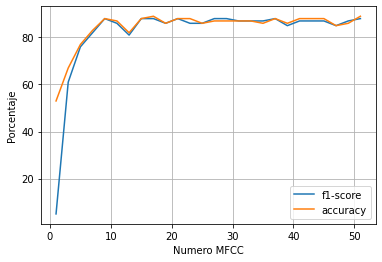

In [ ]:
# Plotting Accuracy and F1-Score of Models

plt.plot(mfccNumbers,f1Scores,  label='f1-score')
plt.plot(mfccNumbers,accuracys, label='accuracy', )
plt.xlabel('Numero MFCC')
plt.ylabel('Porcentaje')
plt.legend()
plt.grid(True)

In [ ]:
f1Scores = []
mfccNumbers = []
accuracys = []

N_MFCC = 1
for i in range(len(reports)):
  print(f'\n\nN_MFCC {N_MFCC}')
  print(f'Classification Report {i}: \n\n', reports[i])
  mfccNumbers.append(N_MFCC)
  f1Scores.append(float(reports[i].split()[7]))
  accuracys.append(float(reports[i].split()[15]))
  N_MFCC += 2



N_MFCC 1
Classification Report 0: 

               precision    recall  f1-score   support

           0       1.00      0.03      0.05       180
           1       0.52      1.00      0.69       192

    accuracy                           0.53       372
   macro avg       0.76      0.51      0.37       372
weighted avg       0.75      0.53      0.38       372



N_MFCC 3
Classification Report 1: 

               precision    recall  f1-score   support

           0       0.73      0.52      0.61       180
           1       0.65      0.82      0.72       192

    accuracy                           0.67       372
   macro avg       0.69      0.67      0.67       372
weighted avg       0.69      0.67      0.67       372



N_MFCC 5
Classification Report 2: 

               precision    recall  f1-score   support

           0       0.78      0.74      0.76       180
           1       0.77      0.80      0.78       192

    accuracy                           0.77       372
   macro av

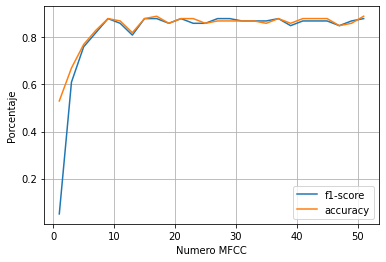

In [ ]:
# Plotting Accuracy and F1-Score of Models

plt.plot(mfccNumbers,f1Scores,  label='f1-score')
plt.plot(mfccNumbers,accuracys, label='accuracy', )
plt.xlabel('Numero MFCC')
plt.ylabel('Porcentaje')
plt.legend()
plt.grid(True)

#Save the entire model as a SavedModel.

In [ ]:
#!mkdir -p saved_model

model.save('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/siren/saved_siren')

#Reload a fresh Keras model from the saved model

In [ ]:
import IPython.display
import librosa
import librosa.display
import pandas as pd
import os
import struct
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint 
from datetime import datetime
from sklearn import metrics 
import librosa as lb
import IPython.display as ipd
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
def predict(path):
    num_rows = 40
    num_columns = 174
    num_channels = 1
    audio = extract_features(path)
    audioP = audio.reshape(1, num_rows, num_columns, num_channels)
    probOut = model.predict(audioP)[0]
    indexMax = np.argmax(probOut)
    print(probOut)
    print(indexMax)
    maxProb = probOut[indexMax]
    if(maxProb>0.95):
      if(indexMax==0):
        classP = 'siren'
      else:
        classP = 'non_siren'
    else:
      classP = 'None'
    print('Class predicted :',classP,'\n\n')
    return ipd.Audio(path)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/siren/saved_siren')

# Check its architecture
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 39, 173, 16)       80        
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 19, 86, 16)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 19, 86, 16)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 18, 85, 32)        2080      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 9, 42, 32)        0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 9, 42, 32)        

In [ ]:
predict('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/UrbanSound8K/audio/fold7/102853-8-0-1.wav')


1/1 [==============================] - 0s 97ms/step
[0.9679626  0.03203743]
0
Class predicted : siren 




In [ ]:
predict('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/UrbanSound8K/audio/fold1/102305-6-0-0.wav')

1/1 [==============================] - 0s 21ms/step
[0.01851141 0.9814886 ]
1
Class predicted : non_siren 




#To record and save audio directly on colab

In [ ]:
#Se implementan funciones para grabar y guardar audio directamente desde el colab
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1200))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  return audio

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def recordAndSave(sec=3, path="audio.wav"):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1200))
  b = b64decode(s.split(',')[1])
  with open(path,'wb') as f:
    f.write(b)
  return path  # or webm ?

In [ ]:
#Grabar porción de audio directamente desde el colab
pathaudio2 = recordAndSave(sec=3,path='/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/sonidosPrueba/prueba1.wav')

<IPython.core.display.Javascript object>

In [ ]:
#Se predice el audio que fue grabado anteriormente
predict(pathaudio2)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[0.9985104  0.00148962]
0
Class predicted : gun_shot 




In [ ]:
#Grabar porción de audio directamente desde el colab
pathaudio3 = recordAndSave(sec=3,path='/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/sonidosPrueba/prueba2.wav')

<IPython.core.display.Javascript object>

In [ ]:
#Se predice el audio que fue grabado anteriormente
predict(pathaudio3)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[3.7462482e-07 9.9999964e-01]
1
Class predicted : siren 


